Power Method
-------------

In [1]:
import numpy as np
import xarray as xr


ds_1 = xr.open_dataset("data/regions_verify_isotope_202112_cov.nc")
bio_1 = ds_1["covariance_bio"]
anth_1 = ds_1["covariance_anth"]

ds_2 = xr.open_dataset("data/regions_verify_202104_cov.nc")
bio_2 = ds_2["covariance_bio"]
anth_2 = ds_2["covariance_anth"]

M = anth_2.values

In [2]:
#!/usr/bin/env python3

import numpy as np

def first_eigvec(A, n_iterations: int):
    """A slightly modified version of
    the function power_iteration retrieved from 
    https://en.wikipedia.org/wiki/Power_iteration
    (Retrieved: 8.9.2022)
    Function computes an estimation
    of the eigenvector corresponding
    to the largest eigenvalue of 
    2-D array A"""
    w0 = np.random.rand(A.shape[1])
    norm = np.linalg.norm(w0)
    #normalize
    w0 = w0 / norm

    for j in np.arange(n_iterations):
        # calculate the matrix-by-vector product Ab
        wj = A.dot(w0)

        # calculate the norm
        norm = np.linalg.norm(wj)

        # re normalize the vector
        w0 = wj / norm

    return w0

def rayleigh_quotient(A, v):
    """Function computes the rayleigh quotient for 2-d numpy array A and normalized vector v.
    (Because v normalized, the denominator v.T.dot(v)=1, and can thus be omitted.)
    If v is an eigenvector of A, the quotient gives the corresponding eigenvalue."""
    mu = v.T.dot(A).dot(v)
    return mu

def residual_norm(A, v, mu):
    """Compute the 2-norm of the residual vector r = Av-av, where
    A is a 2-d numpy array, v an approximated eigenvector and a is an approximation of
    corresponding eigenvalue. Can be used to evaluate the accuracy of the estimated
    eigenvector and -value."""
    r = A.dot(v)-mu*v
    norm = np.linalg.norm(r)
    return norm

def hotelling2(A, v, mu, n_iterations):
    """Function to compute the second eigenvector after the largest
    eigenvalue and corresponding eigenvector has been computed.
    Function utilizes Hotelling's method.
    Parameters:
    A : 2D array
    v : 1D array. Eigenvector corresponding to the largest eigenvalue of A. 
    a : float. Largest eigenvalue of A.
    num_simulations : int"""
    w0 = np.random.rand(A.shape[1])
    norm = np.linalg.norm(w0)
    #normalize
    w0 = w0 / norm

    for i in np.arange(n_iterations):
        wi = A.dot(w0)-mu*v*(v.T.dot(w0))

        norm = np.linalg.norm(wi)

        #normalize
        w0 = wi / norm

    return w0

def hotelling(A, v, mu, n_vectors, n_iterations):
    """Function that uses Hotelling's deflation
    method to compute the eigenvectors that
    correspond to the second, third, ... , (n_vectors)th
    largest eigenvalues along
    with their corresponding eigenvector. The largest eigenvalue
    and corresponding eigenvector need to have been computed first.
    Returns n_vectors eigenvectors as rows of an array and the eigenvalues
    as a list in descending order"""

    n = A.shape[1]
    #array for storing the eigenvectors as its rows
    V_T = v

    #list for storing the eigenvalues
    mu_s = np.array(mu)

    #array with mu*v as columns
    V_mu = mu*v
    

    #each new eigenvector and eigenvalue computed iteratively
    #using the previously computed ones
    for i in np.arange(n_vectors-1):
        
        #initial guess
        w0 = np.random.rand(n)
        norm = np.linalg.norm(w0)
        #normalize
        w0 = w0/norm
    
        #power iteration
        for j in np.arange(n_iterations):
            #Hotelling's deflation
            wj = A.dot(w0)-V_mu.dot(V_T.dot(w0))

            norm = np.linalg.norm(wj)

            #normalize
            w0 = wj / norm
        
        #calculate corresponding eigenvalue
        mu0 = rayleigh_quotient(A, w0)

        # store the eigenvector and eigenvalues 
        V_T = np.row_stack((V_T, w0))
        mu_s = np.append(mu_s, mu0)
        V_mu = np.column_stack((V_mu, mu0*w0))

    return V_T, mu_s 

def power_method(A, n_vectors, n_iterations):
    """Function estimates the n_vectors eigenvectors
    with largest eigenvalues of 2-D array A using
    the power method. Returns the estimated eigenvectors
    as rows in an array and the estimated eigenvalues as a list"""

    # compute the eigenvector with
    # the largest eigenvalue
    v = first_eigvec(A, n_iterations)
    mu = rayleigh_quotient(A, v)

    if n_vectors < 2:
        return v, mu
    else:
        #compute the other eigenvectors and eigenvalues
        #using Hotelling's deflation and Rayleigh quotient
        V_T, mu_s = hotelling(A, v, mu, n_vectors, n_iterations)
        return V_T, mu_s

In [25]:






#OBS! NEED TO CHECK IF THERE IS A DIFFERENCE IN SPEED WITH A.dot(v) vs. np.dot(A, v)



In [32]:

u = np.ones(5)
w = np.ones(5)*2
u_T = np.array([u])
uw_T = np.row_stack((u,w))
uw = np.column_stack((u,w))
print(uw)
print(uw_T)
print(uw_T.dot(uw))

[[1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]]
[[1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2.]]
[[ 5. 10.]
 [10. 20.]]


In [ ]:
def proj(v,w):
    """Compute the projection of v onto span(w).
    Parameters: v : list or 1-d numpy array
                w : list or 1-d numpy array"""
    p = v.dot(w)/(w.dot(w))*w
    return p

def perp(v, ws):
    """Compute the kohtisuora komponentti of v against subspace span(ws)
    Parameters: v : list or 1-d numpy array
                ws : a list of lists or 1-d numpy arrays. These have to
                be orthogonal"""
    projections = [proj(v,w) for w in ws]
    return v-np.sum(projections, axis=0)


Below the "real" eigenvalues and eigenvectors
----------------------------------------------

In [3]:


#compute eigenvalues and eigenvectors of M. Note: np.linalg.eigh gives eigenvalues in ascending order, 
# so the largest is last, and so is the corresponding eigenvector. 
# (NOTE: Don't need to worry abot how the order treats negative values as all eigenvalues of a positive semidefinite matrix are nonnegative)

evals, evecs = np.linalg.eigh(M) 
#largest eigenvalue and corresponding evec
eval1, evec1 = evals[-1], evecs[-1]
#second largest
eval2, evec2 = evals[-2], evecs[-2]




In [68]:
print(evals.shape)

(6858,)


In [4]:

print(evals[range(-1,-11,-1)])



[15.15454765 11.69482561 10.32612078  9.96130532  9.89193315  9.75719582
  9.24783414  9.15443245  8.89805937  8.89677888]


In [40]:

iterations = np.arange(1,16)
VT, power_evals = power_method(M,3,1) 
for i in range(1,15):
    V_T, mu_s = power_method(M,3,iterations[i])
    power_evals = np.row_stack((power_evals,mu_s))


print(power_evals)

[[ 8.95015379  5.03796752  5.39026672]
 [10.28455441 11.62341016  8.94869316]
 [11.75812748 13.41428505 10.41673473]
 [13.10486328 13.01677628 10.39477457]
 [13.45744177 12.94227662 10.56029955]
 [14.49098743 12.02012375 10.25989743]
 [14.73353013 11.88830848 10.12184756]
 [14.94936276 11.6738907  10.05545556]
 [14.96762814 11.77543505 10.01945319]
 [15.05941372 11.68432194  9.96079893]
 [15.10690087 11.65535614 10.00608674]
 [15.12905192 11.63898862 10.02038972]
 [15.1385499  11.66326257 10.02296763]
 [15.14477442 11.66880772 10.0594831 ]
 [15.14958066 11.67197106 10.08503915]]


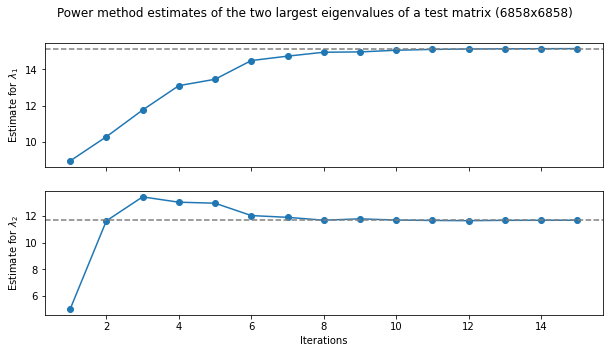

In [43]:
import matplotlib.pyplot as plt
labels = [r'$\lambda_1$', r'$\lambda_2$', r'$\lambda_3$']

fig, axs = plt.subplots(2,1, figsize = (10,5), sharex='col')
for i in range(2):
    axs[i].plot(iterations, power_evals[:,i], marker = 'o')
    axs[i].axhline(y=evals[-(i+1)], linestyle = 'dashed', color = 'grey')
    axs[i].set_ylabel(f"Estimate for {labels[i]}")
axs[1].set_xlabel("Iterations")
fig.suptitle("Power method estimates of the two largest eigenvalues of a test matrix (6858x6858)")
plt.tight_layout
plt.show()

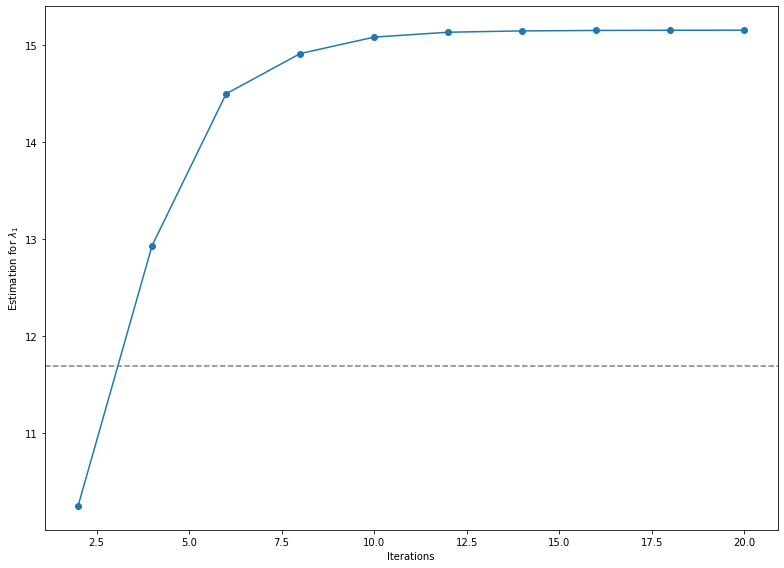

In [36]:
fig, ax = plt.subplots(figsize = (11,8), layout = 'tight', sharex='row')
ax.plot(iterations, power_evals[:,0], marker = 'o')
ax.axhline(y=evals[-(i+1)], linestyle = 'dashed', color = 'grey')
ax.set_ylabel(f"Estimation for {labels[0]}")
ax.set_xlabel("Iterations")
plt.show()

In [75]:
largest_evecs = evecs[range(-1,-11,-1)]
residuals = []
diffs = []
for i in range(10):
    residual = residual_norm(M, V_T[i], mu_s[i])
    residuals.append(residual)
    diff = np.linalg.norm(largest_evecs[i]-V_T[i])
    diffs.append(diff)
print(residuals)
print(diffs)




[3.4060245772776416e-11, 3.618968745565533e-06, 0.009194577471923478, 0.024766905747349317, 0.02288058312727909, 0.04620733890848414, 0.0492595791563369, 0.0848178556572693, 0.0868597470467658, 0.12367572420895566]
[1.4142135623730951, 1.4142135623730945, 1.4142135623717602, 1.4142135622969043, 1.4142135623339784, 1.4142135586715225, 1.414213514188876, 1.414213525606388, 1.4142134352976992, 1.414213321693363]


In [67]:
eval1/eval2

1.295833572422536

In [58]:
print(largest_evecs[0])
print(V_T[0])

[0. 0. 0. ... 0. 0. 0.]
[1.02238389e-17 3.17420128e-17 4.43083516e-17 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [18]:

# check if the real and approximated eigenvector linearly dependent
A = np.stack((v_2, evec2), axis=1)
np.linalg.matrix_rank(A)



2

11.694825610284667


In [7]:
for i in np.arange(len(evec1)):
    x = evec1[i]
    if x != 0.0:
        print(i,x)

11 1.0


In [51]:
for i in range(50,400,50):
    v_2 = hotelling2(M, v, a, i)
    a_2 = rayleigh_quotient(M, v_2)
    norm = residual_norm(M, v_2, a_2)
    print(f"Iteration {i}, residual norm: {norm}")
    

Iteration 50, residual norm: 0.002694597137400284
Iteration 100, residual norm: 0.00023027591081764133
Iteration 150, residual norm: 6.717010804712341e-05
Iteration 200, residual norm: 0.00014071462095937545
Iteration 250, residual norm: 0.00015732072384204554
Iteration 300, residual norm: 0.00018789944059598136
Iteration 350, residual norm: 1.0853296793970103e-06


In [49]:
#print(f"Real eigval: {eval1}")


for i in range(100,1000, 100):
    v = power_iteration(M, i)
    a = rayleigh_quotient(M, v)
    norm = residual_norm(M, v, a)
    print(f"Iteration: {i}, residual norm: {norm}")
    #print(f"Iteration: {i}, estimated eigval: {a}, residual norm: {norm}")
    
    

Iteration: 100, residual norm: 1.0367997085054587e-07
Iteration: 200, residual norm: 2.0375336947625995e-13
Iteration: 300, residual norm: 5.551169297415832e-17
Iteration: 400, residual norm: 5.551157474611588e-17
Iteration: 500, residual norm: 5.551157474611588e-17
Iteration: 600, residual norm: 5.551157474611588e-17
Iteration: 700, residual norm: 5.551157474611588e-17
Iteration: 800, residual norm: 5.551157474611588e-17
Iteration: 900, residual norm: 5.551157474611588e-17
